<a href="https://colab.research.google.com/github/debruit/aprendizajeMaquina/blob/main/Proyectofinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final aprendizaje 

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import shutil
import joblib
from PIL import Image

import tensorflow as tf
import tensorflow.keras as kr

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



## Carga de los datos

In [ ]:
# Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
! pip install -q kaggle

Los 

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debruit","key":"d2d600954d6491f4e516ae8fb8691519"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 59% 37.0M/63.2M [00:00<00:00, 50.9MB/s]
100% 63.2M/63.2M [00:00<00:00, 88.2MB/s]


In [ ]:
shutil.unpack_archive("age-gender-and-ethnicity-face-data-csv.zip")

##Exploración de los datos

*   Edad: Entero entre 1 y 93. 
*   Etnicidad: Entero con etiquetas que representan:


1.   0 representa caucasicos.
2.   1 representa afrodescendientes.
3.   2 representa asiaticos.
4.   3 representa hindues. 
5.   4 representa latinos.


*   Genero: Entero con etiquetas 

1.   0 representa Hombre.
2.   1 representa Mujer.

*   Imagen: String que contiene una imagen de 48 x 48.  



In [ ]:
base=pd.read_csv("age_gender.csv")
base.head(5)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [ ]:
genero = base["gender"].value_counts()
prc_genero = genero/len(base)
print(genero)
print(prc_genero)

# Existen 12391 hombres correspondiente al 52.3% de los datos
# Existen 11314 mujeres correspondiente al 47.7% de los datos

0    12391
1    11314
Name: gender, dtype: int64
0    0.522717
1    0.477283
Name: gender, dtype: float64


In [ ]:
etnia = base["ethnicity"].value_counts()
prc_etnia = etnia/len(base)
print(etnia)
print(prc_etnia)

# Existen 10078 caucásicos correspondiente al 42.5% de los datos
# Existen 4526 afrodescendientes correspondiente al 19.1% de los datos
# Existen 3975 hindúes correspondiente al 16.8% de los datos
# Existen 3434 asiáticos correspondiente al 14.5% de los datos
# Existen 1692 latinos correspondiente al 7.1% de los datos

0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64
0    0.425142
1    0.190930
3    0.167686
2    0.144864
4    0.071377
Name: ethnicity, dtype: float64


##### Rangos de edad

*   Primera Infancia (0-5 años)
*   Infancia (6 - 13 años)
*   Juventud (14 - 26 años)
*   Adultez (27- 59 años)
*   Persona Mayor (60 años o mas) envejecimiento y vejez.

In [ ]:
pr_infancia = base[base["age"] < 6]
infancia = base[base["age"] > 5]
infancia = infancia[infancia["age"] < 14]
juventud = base[base["age"] > 13]
juventud = juventud[juventud["age"] < 27]
adultez = base[base["age"] > 26]
adultez = adultez[adultez["age"] < 60]
prs_mayor = base[base["age"] >= 60]

prc_pr_infancia = len(pr_infancia)/len(base)
prc_infancia = len(infancia)/len(base)
prc_juventud = len(juventud)/len(base)
prc_adultez = len(adultez)/len(base)
prc_prs_mayor = len(prs_mayor)/len(base)


print("Primera infancia: {} personas - correspondiente al {}% de los datos\n".format(len(pr_infancia),round(prc_pr_infancia*100)))
print("Infancia: {} personas - correspondiente al {}% de los datos\n".format(len(infancia),round(prc_infancia*100)))
print("Juventud: {} personas - correspondiente al {}% de los datos\n".format(len(juventud),round(prc_juventud*100)))
print("Adultez: {} personas - correspondiente al {}% de los datos\n".format(len(adultez),round(prc_adultez*100)))
print("Persona Mayor: {} personas - correspondiente al {}% de los datos\n".format(len(prs_mayor),round(prc_prs_mayor*100)))

Primera infancia: 2363 personas - correspondiente al 10% de los datos

Infancia: 1131 personas - correspondiente al 5% de los datos

Juventud: 6340 personas - correspondiente al 27% de los datos

Adultez: 11183 personas - correspondiente al 47% de los datos

Persona Mayor: 2688 personas - correspondiente al 11% de los datos



#### Ejemplo comparación de imágenes de niños y niñas en primera infancia 

In [ ]:
def transformar(img):
  img_float = np.array(img.split(" "), dtype=np.uint16).reshape(48, 48)
  return img_float

def graficar(img):
  plt.imshow(img,"gray")

In [ ]:
etnia=base[base["gender"] == 1]
etnia=etnia[etnia["age"] < 10]
etnia.head(100)

,age,ethnicity,gender,img_name,pixels
641,1,3,1,20161219225035448.jpg.chip.jpg,219 168 61 49 116 176 144 96 158 186 189 193 1...
642,1,3,1,20161219225027497.jpg.chip.jpg,90 100 133 151 153 164 168 171 174 180 179 182...
643,1,3,1,20161219225024289.jpg.chip.jpg,93 90 89 83 90 113 123 124 126 130 133 135 136...
644,1,3,1,20161219225018384.jpg.chip.jpg,7 6 7 9 10 12 14 17 24 31 36 41 44 46 53 63 74...
645,1,3,1,20161219225015272.jpg.chip.jpg,49 88 106 106 107 105 106 109 107 102 105 115 ...
...,...,...,...,...,...
737,1,2,1,20161219221241583.jpg.chip.jpg,175 186 188 180 183 177 142 102 103 87 100 108...
738,1,2,1,20161219221237927.jpg.chip.jpg,120 123 127 133 140 144 144 142 144 158 162 16...
739,1,2,1,20161219221229279.jpg.chip.jpg,138 159 165 174 182 183 171 164 151 141 132 12...
740,1,2,1,20161219221154447.jpg.chip.jpg,172 186 196 203 212 210 208 204 197 189 182 17...


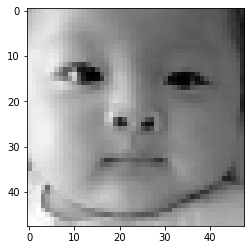

In [ ]:
img=etnia.loc[740]["pixels"]
img=transformar(img)
graficar(img)

# Imagen de una niña asiática de un año

In [ ]:
etnia=base[base["gender"] == 0]
etnia=etnia[etnia["age"] < 10]
etnia.head(100)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
95,1,2,0,20161219204848341.jpg.chip.jpg,133 213 218 221 216 207 184 211 220 239 235 24...
96,1,2,0,20161219204858548.jpg.chip.jpg,62 55 97 148 169 187 194 189 191 197 195 190 1...
97,1,2,0,20161219204634589.jpg.chip.jpg,200 204 205 207 208 212 213 216 217 217 215 21...
98,1,2,0,20161219204951309.jpg.chip.jpg,245 236 239 234 220 233 237 216 234 214 208 21...


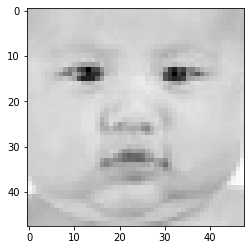

In [ ]:
img=etnia.loc[97]["pixels"]
img=transformar(img)
graficar(img)

# Imagen de un niño asiático de un año

## Interfaz de usuario

In [ ]:
# El usuario sube una imagen
foto = files.upload()

In [ ]:
image = Image.open(list(foto.keys())[0])
# convert image to numpy array
img_data = np.asarray(image)
# summarize shape
print(img_data.shape)


##### Clase predicción para cargar los modelos, inicializar los pesos, sacar el promedio de las votaciones de los modelos, y graficar los resultados

In [ ]:
class Prediccion:
  modelosSexo = []
  modelosEdad = []
  modelosEtnia = []
  pesosSexo = []
  pesosEdad = []
  pesosEtnia = []

  def __init__(self) -> None:
    self.modelosSexo = []
    self.modelosEdad = []
    self.modelosEtnia = []
    self.pesosSexo = []
    self.pesosEdad = []
    self.pesosEtnia = []

  def setModelos(self, modelos, caracteristica):
    if caracteristica == 'sexo':
      for m in modelos:
        self.modelosSexo.append(m)
    elif caracteristica == 'edad':
      for m in modelos:
        self.modelosEdad.append(m)
    elif caracteristica == 'etnia':
      for m in modelos:
        self.modelosEtnia.append(m)

  def setPesos(self, pesos, caracteristica):
    if caracteristica == 'sexo':
      for p in pesos:
        self.pesosSexo.append(p)
    elif caracteristica == 'edad':
      for p in pesos:
        self.pesosEdad.append(p)
    elif caracteristica == 'etnia':
      for p in pesos:
        self.pesosEtnia.append(p)

  def ponderado(self,pesos,modelos,img):
    res = 0
    for p, m in zip(pesos, modelos):
      v = m.predict(img)
      if len(v.shape) > 1:
        if v.shape[1] > 1:
          v = np.argmax(v[0])
      res += p*v
    return int(np.round(res))

  def predecir_edad(self,img):
    predicho = self.ponderado(self.pesosEdad,self.modelosEdad,img)
    return int(predicho)

  def predecir_etnia(self,img):
    predicho = self.ponderado(self.pesosEtnia,self.modelosEtnia,img)
    etnias = {
        0: "caucásico",
        1: "afrodescendiente",
        2: "asiático",
        3: "hindú",
        4: "latino"
    }
    return etnias[predicho]

  def predecir_genero(self,img):
    predicho = self.ponderado(self.pesosSexo,self.modelosSexo,img)
    generos = {
        0: "hombre",
        1: "mujer"
    }
    return generos[predicho]

  def predecir_descripciones(self,img):
    edad = self.predecir_edad(img)
    etnia = self.predecir_etnia(img)
    genero = self.predecir_genero(img)
    return [edad, etnia, genero]
  
  def graficar(self,img,descripciones):
    plt.imshow(img,"gray")
    plt.title('Edad: {0} años\n Etnia: {1}\n Género: {2}'.format(descripciones[0],descripciones[1],descripciones[2],loc="left",color='red',fontsize = 20))
    plt.show()

##### Procesamiento de la imagen dada por el usuario

In [ ]:

def corregirEscala(img):
  tam=img.shape
  if(len(tam)==3):
    if(tam[2]==1):
      img=img.squeeze()
    else:
      img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  return img

def corregirTam(img):
   tam=img.shape
   if(tam[0]!= 48 or  tam[1]!= 48):
     img=cv2.resize(img,(48,48),cv2.INTER_AREA)
   return img

def preProcesar(img):
  if( type(img)==np.ndarray):
    img=corregirEscala(img)
    img=corregirTam(img)
    return img
  else:
    print("Error : El formato de imagen es incompatible")
    return(-1)

In [ ]:
img_procesada = preProcesar(img_data)

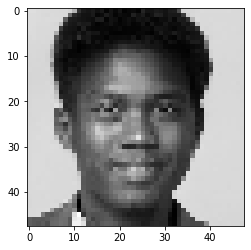

In [ ]:
graficar(img_procesada)

In [ ]:
img_fila = img_procesada.reshape(1,2304)

In [ ]:
prd = Prediccion()

##### Carga de los modelos para cada característica

In [ ]:
mod_sexo = [joblib.load("redSex.pkl"),joblib.load("SVMSexo.pkl"),joblib.load("RegLogisticaSexo.pkl")]
prd.setModelos(mod_sexo, 'sexo')

In [ ]:
mod_edad = [joblib.load("RegLinealEdad.pkl"),joblib.load("modelReluEdad.pkl"),joblib.load("modelTanhEdad.pkl")]
prd.setModelos(mod_edad, 'edad')

In [ ]:
mod_etnia = [joblib.load("RedEtnia.pkl"),joblib.load("multiRegLogEtnia.pkl"),joblib.load("multiSVMEtnia.pkl")]
prd.setModelos(mod_etnia, 'etnia')

#### Inicialización de pesos para cada modelo de cada característica

In [ ]:
pesos_sexo = [0.1,0.3,0.6]
pesos_edad = [0.4,0.3,0.3]
pesos_etnia = [0.05,0.55,0.4]

prd.setPesos(pesos_sexo, 'sexo')
prd.setPesos(pesos_edad, 'edad')
prd.setPesos(pesos_etnia, 'etnia')

#### Predicción de los modelos y gráfica de resultados

v [[35.38645794]]
[[14.15458318]]
v [[39.623444]]
[[26.04161664]]
v [[33.451298]]
[[36.07700654]]
v [[0.23392542 0.15793666 0.20611502 0.14927089 0.252752  ]]
0.4
v [1]
[0.9]
v [1]
[1.3]
v [[0.26297542 0.16486424]]
0.0
v [0]
[0.]
v [0]
[0.]


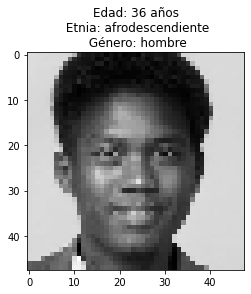

In [ ]:
descripciones = prd.predecir_descripciones(img_fila)
prd.graficar(img_procesada,descripciones)

## Preparación de los datos

In [ ]:
imagenes=base["pixels"]
data=[]
for i in imagenes:
  data.append(np.array(i.split(" "), dtype=np.uint16))

imagenes=pd.DataFrame(data)
imagenes.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,129,128,128,126,127,130,133,135,139,142,...,123,129,134,138,142,144,144,146,146,146
1,164,74,111,168,169,171,175,182,184,188,...,168,189,223,241,236,232,204,182,170,148
2,67,70,71,70,69,67,70,79,90,103,...,117,113,116,116,117,117,115,112,111,108
3,193,197,198,200,199,200,202,203,204,205,...,218,222,227,228,228,230,231,235,239,246
4,202,205,209,210,209,209,210,211,212,214,...,165,167,167,167,168,171,171,167,163,161


In [ ]:
datasetEdad = imagenes.assign(age=base["age"])
datasetSexo = imagenes.assign(gender=base["gender"])
datasetEtnia = imagenes.assign(ethnicity=base["ethnicity"])


In [ ]:
datasetEdad.to_csv('datasetEdad.csv')
datasetSexo.to_csv('datasetSexo.csv')
datasetEtnia.to_csv('datasetEtnia.csv')

## Entrenamiento

### Clasificador Etnia

In [ ]:
trainEtnia, testEtnia = train_test_split(datasetEtnia, test_size = 0.3, shuffle = True)

grupos1Etnia= trainEtnia.sample(frac=0.33, replace=False)
grupos2Etnia= trainEtnia.sample(frac=0.33, replace=False)
grupos3Etnia= trainEtnia.sample(frac=0.33, replace=False)


#### Multiclasificador SVM

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

clf = OneVsOneClassifier(LinearSVC(C=1e-8,random_state=123)).fit(grupos1Etnia.iloc[:,:-1], grupos1Etnia.iloc[:,-1:])
clf.predict(grupos1Etnia.iloc[:,:-1])
ypredict=clf.predict(grupos1Etnia.iloc[:,:-1])
res=accuracy_score(grupos1Etnia.iloc[:,-1:], ypredict)
print(res)
print(confusion_matrix(grupos1Etnia.iloc[:,-1:], ypredict))
joblib.dump(clf, "multiSVM.pkl")
files.download("multiSVM.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6552227903579255
[[2183   53   55   68    0]
 [ 299  703   19   52    0]
 [ 371   32  347   25    0]
 [ 433   59   23  355    0]
 [ 294   30   26   49    0]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
clf=joblib.load("multiSVM.pkl")
ypredict=clf.predict(testEtnia.iloc[:,:-1])
res=accuracy_score(testEtnia.iloc[:,-1:], ypredict)
print(res)
print(confusion_matrix(testEtnia.iloc[:,-1:], ypredict))

0.640466816647919
[[2767   81   65  120    0]
 [ 397  847   26   79    0]
 [ 500   31  475   32    0]
 [ 609   98   33  466    0]
 [ 367   31   29   59    0]]


#### Red neuronal

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(grupos2Etnia)
dataEtnia=scaler.transform(grupos2Etnia)
valEtnia=scaler.transform(testEtnia)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from IPython.core.display import display, HTML
from keras import callbacks

# learning rate
lr = 1e-5
#lambda
#0.0001
ldPesos=0.0001
ldSezgo= 0.0001
model = kr.Sequential()

model.add(kr.Input(shape=(2304,)))
model.add(kr.layers.Dense(1000, activation='tanh', 
                          kernel_regularizer=tf.keras.regularizers.L2(ldPesos),
                          bias_regularizer=tf.keras.regularizers.L2(ldSezgo)))
model.add(kr.layers.Dense(500, activation='tanh', 
                          kernel_regularizer=tf.keras.regularizers.L2(ldPesos),
                          bias_regularizer=tf.keras.regularizers.L2(ldSezgo)))
model.add(kr.layers.Dense(250, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.L2(ldPesos),
                          bias_regularizer=tf.keras.regularizers.L2(ldSezgo)))
model.add(kr.layers.Dense(125, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.L2(ldPesos),
                          bias_regularizer=tf.keras.regularizers.L2(ldSezgo)))
model.add(kr.layers.Dense(60, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.L2(ldPesos),
                          bias_regularizer=tf.keras.regularizers.L2(ldSezgo)))
model.add(kr.layers.Dense(5, activation='softmax', 
                          kernel_regularizer=tf.keras.regularizers.L2(ldPesos),
                          bias_regularizer=tf.keras.regularizers.L2(ldSezgo)))
print(model.summary())
# Compilamos el modelo, definiendo la función de coste y el optimizador
model.compile(loss='mse', optimizer=kr.optimizers.SGD(learning_rate=lr), metrics=['acc'])

#Para evitar el sobre-entrenamiento
earlystopping = callbacks.EarlyStopping(monitor ="loss", 
                                        mode ="min", patience = 5,
                                        min_delta=0.01, 
                                        restore_best_weights = True)

# Y entrenamos al modelo. Los callbacks
model.fit(dataEtnia[:,:-1], dataEtnia[:,-1:], epochs=200, batch_size=32,
          validation_data =(valEtnia[:,:-1], valEtnia[:,-1:]), 
                    callbacks =[earlystopping])

ypredict=model.predict(grupos2Etnia.iloc[:,:-1])
yres=pd.DataFrame(ypredict).idxmax(axis=1)
res=accuracy_score(grupos2Etnia.iloc[:,-1:], yres)
print(res)
print(confusion_matrix(grupos2Etnia.iloc[:,-1:], yres))
print(res)
joblib.dump(model, "RedEtnia.pkl")
files.download("RedEtnia.pkl")

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 1000)              2305000   
                                                                 
 dense_277 (Dense)           (None, 500)               500500    
                                                                 
 dense_278 (Dense)           (None, 250)               125250    
                                                                 
 dense_279 (Dense)           (None, 125)               31375     
                                                                 
 dense_280 (Dense)           (None, 60)                7560      
                                                                 
 dense_281 (Dense)           (None, 5)                 305       
                                                                 
Total params: 2,969,990
Trainable params: 2,969,990
N

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

ypredict=model.predict(testEtnia.iloc[:,:-1])
print(ypredict)
print(ypredict.shape)

yres=pd.DataFrame(ypredict).idxmax(axis=1)
print(yres)
print(yres.shape)


res=accuracy_score(testEtnia.iloc[:,-1:], yres)
print(res)

[[0.20000362 0.19999816 0.1999966  0.20000157 0.20000008]
 [0.20000362 0.19999816 0.1999966  0.20000157 0.20000008]
 [0.20000362 0.19999816 0.1999966  0.20000157 0.20000008]
 ...
 [0.20000362 0.19999816 0.1999966  0.20000157 0.20000008]
 [0.20000362 0.19999816 0.1999966  0.20000157 0.20000008]
 [0.20000362 0.19999816 0.1999966  0.20000157 0.20000008]]
(7112, 5)
0       0
1       0
2       0
3       0
4       0
       ..
7107    0
7108    0
7109    0
7110    0
7111    0
Length: 7112, dtype: int64
(7112,)
0.42280652418447695


In [ ]:
max=yres.max(axis=0)
print(max)

#### Multilasificador regresion logistica

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression 

clf = OneVsOneClassifier(LogisticRegression(C=1e-6, random_state=123)).fit(grupos3Etnia.iloc[:,:-1], grupos3Etnia.iloc[:,-1:])
clf.predict(grupos3Etnia.iloc[:,:-1])
ypredict=clf.predict(grupos3Etnia.iloc[:,:-1])
res=accuracy_score(grupos3Etnia.iloc[:,-1:], ypredict)
print(res)
print(confusion_matrix(grupos3Etnia.iloc[:,-1:], ypredict))
joblib.dump(clf, "multiRegLog.pkl")
files.download("multiRegLog.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteratio

0.7629656683710738
[[2122   46   67   88    8]
 [ 141  833   20   52    7]
 [ 165   21  579   21    2]
 [ 225   54   27  589    8]
 [ 224   31   19   72   55]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
clf=joblib.load("multiRegLog.pkl")
ypredict=clf.predict(testEtnia.iloc[:,:-1])
res=accuracy_score(testEtnia.iloc[:,-1:], ypredict)
print(res)
print(confusion_matrix(testEtnia.iloc[:,-1:], ypredict))

0.7052868391451068
[[2600   88  124  197   24]
 [ 193  989   37  107   23]
 [ 233   47  701   49    8]
 [ 348   95   47  696   20]
 [ 272   43   47   94   30]]


### Casificador Sexo

In [ ]:
trainSexo, testSexo = train_test_split(datasetSexo, test_size = 0.3, shuffle = True)

grupos1Sexo= trainSexo.sample(frac=0.33, replace=False)
grupos2Sexo= trainSexo.sample(frac=0.33, replace=False)
grupos3Sexo= trainSexo.sample(frac=0.33, replace=False)


#### SVM

In [ ]:
from sklearn.svm import SVC

svm=SVC(C=1/100, kernel="rbf", random_state=123)
svm.fit(grupos1Sexo.iloc[:,:-1], grupos1Sexo.iloc[:,-1:])
ypredict=svm.predict(grupos1Sexo.iloc[:,:-1])
res=accuracy_score(grupos1Sexo.iloc[:,-1:], ypredict)
print(res)
print(confusion_matrix(grupos1Sexo.iloc[:,-1:], ypredict))
joblib.dump(svm, "SVM.pkl")
files.download("SVM.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6829802775748721
[[2483  380]
 [1356 1257]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
svm=joblib.load("SVM.pkl")
ypredict=svm.predict(testSexo.iloc[:,:-1])
res=accuracy_score(testSexo.iloc[:,-1:], ypredict)
print(res)
print(confusion_matrix(testSexo.iloc[:,-1:], ypredict))

0.6760404949381328
[[3246  524]
 [1780 1562]]


#### Regresión logistica

In [ ]:
from sklearn.linear_model import LogisticRegression 

lReg=LogisticRegression(C=1/10, random_state=123)
lReg.fit(grupos2Sexo.iloc[:,:-1], grupos2Sexo.iloc[:,-1:])
ypredict=lReg.predict(grupos2Sexo.iloc[:,:-1])
res=accuracy_score(grupos2Sexo.iloc[:,-1:], ypredict)
print(res)
print(confusion_matrix(grupos2Sexo.iloc[:,-1:], ypredict))
joblib.dump(lReg, "RegLogistica.pkl")
files.download("RegLogistica.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8933528122717312
[[2563  283]
 [ 301 2329]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lReg=joblib.load("RegLogistica.pkl")
ypredict=lReg.predict(testSexo.iloc[:,:-1])
res=accuracy_score(testSexo.iloc[:,-1:], ypredict)
print(res)
print(confusion_matrix(testSexo.iloc[:,-1:], ypredict))

0.8357705286839145
[[3174  596]
 [ 572 2770]]


#### Red neuronal

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(grupos3Sexo)
dataSex=scaler.transform(grupos3Sexo)
valSex=scaler.transform(testSexo)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from IPython.core.display import display, HTML
from keras import callbacks
# learning rate
lr = 1e-5
model = kr.Sequential()
# Añadimos la capa 1
model.add(kr.Input(shape=(2304,)))
model.add(kr.layers.Dense(1000, activation='tanh'))
model.add(kr.layers.Dense(500, activation='tanh'))
model.add(kr.layers.Dense(250, activation='relu'))
model.add(kr.layers.Dense(125, activation='relu'))
model.add(kr.layers.Dense(60, activation='relu'))
model.add(kr.layers.Dense(2, activation='sigmoid'))
print(model.summary())
# Compilamos el modelo, definiendo la función de coste y el optimizador
model.compile(loss='mse', optimizer=kr.optimizers.Adam(learning_rate=lr), metrics=['acc'])

#Para evitar el sobre-entrenamiento
earlystopping = callbacks.EarlyStopping(monitor ="val_acc", 
                                        mode ="max", patience = 2,
                                        min_delta=0.5, 
                                        restore_best_weights = True)

# Y entrenamos al modelo. Los callbacks
h=model.fit(dataSex[:,:-1], dataSex[:,-1:], epochs=40, batch_size=32, 
          validation_data =(valSex[:,:-1], valSex[:,-1:]), 
                    callbacks =[earlystopping])

ypredict=model.predict(grupos3Sexo.iloc[:,:-1])
yres=pd.DataFrame(ypredict).idxmax(axis=1)
res=accuracy_score(grupos3Sexo.iloc[:,-1:], yres)
print(res)
print(confusion_matrix(grupos3Sexo.iloc[:,-1:], yres))
joblib.dump(model, 'redSex.pkl')
files.download('redSex.pkl')

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_384 (Dense)           (None, 1000)              2305000   
                                                                 
 dense_385 (Dense)           (None, 500)               500500    
                                                                 
 dense_386 (Dense)           (None, 250)               125250    
                                                                 
 dense_387 (Dense)           (None, 125)               31375     
                                                                 
 dense_388 (Dense)           (None, 60)                7560      
                                                                 
 dense_389 (Dense)           (None, 2)                 122       
                                                                 
Total params: 2,969,807
Trainable params: 2,969,807
N

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model=joblib.load('redSex.pkl')
ypredict=model.predict(testSexo.iloc[:,:-1])
yres=pd.DataFrame(ypredict).idxmax(axis=1)
res=accuracy_score(testSexo.iloc[:,-1:], yres)
print(res)
print(confusion_matrix(testSexo.iloc[:,-1:], yres))

0.5573678290213723
[[1887 1799]
 [1349 2077]]


### Predicción de Edad

In [ ]:
trainEdad, testEdad = train_test_split(datasetEdad, test_size = 0.3, shuffle = True)

grupos1Edad= trainEdad.sample(frac=0.33, replace=False)
grupos2Edad= trainEdad.sample(frac=0.33, replace=False)
grupos3Edad= trainEdad.sample(frac=0.33, replace=False)

#### Regresión lineal

In [ ]:
from sklearn.linear_model import LinearRegression 


linear=LinearRegression()
linear.fit(grupos1Edad.iloc[:,:-1], grupos1Edad.iloc[:,-1:])
ypredict=linear.predict(grupos1Edad.iloc[:,:-1])
res=mean_squared_error(grupos1Edad.iloc[:,-1:], ypredict)
print(res)
joblib.dump(linear, "RegLineal.pkl")
files.download("RegLineal.pkl")

102.73512697298455


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
linear=joblib.load("RegLineal.pkl")
ypredict=linear.predict(testEdad.iloc[:,:-1])
res=mean_squared_error(testEdad.iloc[:,-1:], ypredict)
print(res)

350.5792410535298


#### Modelo red neuronal  tangente hiperbolica

In [ ]:
from IPython.core.display import display, HTML
lr = 1e-4
model = kr.Sequential()

model.add(kr.Input(shape=(2304,)))
model.add(kr.layers.Dense(1000, activation='tanh'))
model.add(kr.layers.Dense(500, activation='tanh'))
model.add(kr.layers.Dense(100, activation='tanh'))
model.add(kr.layers.Dense(1))
print(model.summary())
# Compilamos el modelo, definiendo la función de coste y el optimizador
model.compile(loss='mse', optimizer=kr.optimizers.Adam(learning_rate=lr))
# Y entrenamos al modelo. Los callbacks
model.fit(grupos2Edad.iloc[:,:-1], grupos2Edad.iloc[:,-1:], epochs=40, batch_size=32)
joblib.dump(model, 'modelTanh.pkl')
files.download('modelTanh.pkl')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              2305000   
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dense_6 (Dense)             (None, 100)               50100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,855,701
Trainable params: 2,855,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
172/172 [==============================] - 6s 30ms/step - loss: 842.4850
Epoch 2/40
172/172 [==============================] - 5s 31ms/step - loss: 754.8057
Epo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mTanh=joblib.load('modelTanh.pkl')
ypredict=mTanh.predict(testEdad.iloc[:,:-1])
res=mean_squared_error(testEdad.iloc[:,-1:], ypredict)
print(res)

391.4906864546602


#### Modelo red neuronal relu

In [ ]:
from IPython.core.display import display, HTML
lr = 1e-4
model = kr.Sequential()

model.add(kr.Input(shape=(2304,)))
model.add(kr.layers.Dense(1000, activation='relu'))
model.add(kr.layers.Dense(500, activation='relu'))
model.add(kr.layers.Dense(100, activation='relu'))
model.add(kr.layers.Dense(1))
print(model.summary())
# Compilamos el modelo, definiendo la función de coste y el optimizador
model.compile(loss='mse', optimizer=kr.optimizers.Adam(learning_rate=lr))
# Y entrenamos al modelo. Los callbacks
model.fit(grupos3Edad.iloc[:,:-1], grupos3Edad.iloc[:,-1:], epochs=40, batch_size=32)
joblib.dump(model, 'modelRelu.pkl')
files.download('modelRelu.pkl')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 1000)              2305000   
                                                                 
 dense_34 (Dense)            (None, 500)               500500    
                                                                 
 dense_35 (Dense)            (None, 100)               50100     
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 2,855,701
Trainable params: 2,855,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
172/172 [==============================] - 4s 23ms/step - loss: 1079.3508
Epoch 2/40
172/172 [==============================] - 4s 23ms/step - loss: 351.6872
Ep

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mTanh=joblib.load('modelRelu.pkl')
ypredict=mTanh.predict(testEdad.iloc[:,:-1])
res=mean_squared_error(testEdad.iloc[:,-1:], ypredict)
print(res)

259.6146758209245


## Pruebas

In [ ]:
def get_key(val,dicti):
    for key, value in dicti.items():
         if val == value:
             return key

#### Pruebas de los modelos de la característica Sexo con sus datos de prueba

In [ ]:
dictSexo = {
        0: "hombre",
        1: "mujer"
    }

In [ ]:
listSexo = []
for i in range(len(testSexo)):
  print(i)
  img = np.expand_dims(testSexo.iloc[i,:-1], axis = 0)
  listSexo.append(prd.predecir_genero(img))

In [ ]:
sexos = np.array(listSexo)

In [ ]:
acc_sexo = []
for sexo in sexos:
  acc_sexo.append(get_key(sexo,dictSexo))

In [ ]:
res=accuracy_score(testSexo.iloc[:,-1:], acc_sexo)
print(res)
print(confusion_matrix(testSexo.iloc[:,-1:], acc_sexo))

0.8416760404949382
[[3209  543]
 [ 583 2777]]


#### Pruebas de los modelos de la característica Etnia con sus datos de prueba

In [ ]:
dictEtnia = {
        0: "caucásico",
        1: "afrodescendiente",
        2: "asiático",
        3: "hindú",
        4: "latino"
    }

In [ ]:
listEtnia = []
for i in range(len(testEtnia)):
  print(i)
  img = np.expand_dims(testEtnia.iloc[i,:-1], axis = 0)
  listEtnia.append(prd.predecir_etnia(img))

In [ ]:
etnias = np.array(listEtnia)

array(['caucásico', 'afrodescendiente', 'caucásico', ..., 'caucásico',
       'asiático', 'asiático'], dtype='<U16')

In [ ]:
acc_etnia = []
for etnia in etnias:
  acc_etnia.append(get_key(etnia,dictEtnia))

In [ ]:
res=accuracy_score(testEtnia.iloc[:,-1:], acc_etnia)
print(res)
print(confusion_matrix(testEtnia.iloc[:,-1:], acc_etnia))

0.6422947131608548
[[2677  180  172   65    3]
 [ 200  980  108   48    1]
 [ 234  303  497   17    0]
 [ 331  107  287  414    1]
 [ 282   78   80   47    0]]


#### Pruebas de los modelos de la característica Edad con sus datos de prueba

In [ ]:
listEdades = []
for i in range(len(testEdad)):
  print(i)
  img = np.expand_dims(testEdad.iloc[i,:-1], axis = 0)
  listEdades.append(prd.predecir_edad(img))

In [ ]:
edades = np.array(listEdades)

In [ ]:
res=mean_squared_error(testEdad.iloc[:,-1:], edades)
print(res)

210.33014623172105
